## Preface
This kernel contains my final submission for the Quora Insincere Questions Classification Competition.
I came up with this model from discussions and public kernels. The model itself (loosely) resembles the 1st place solution from this discussion [thread](https://www.kaggle.com/c/quora-insincere-questions-classification/discussion/80568) by Psi. I took the liberty to integrate Attention and GRU in an attempt to enhance the model.

Currently this kernel stands at:
* Private LB : 0.7056 (ish)
* Public LB : 0.699 (ish)

My initial plan was to train an off-the-shelf ULMFiT language model from FastAI and then fine tuning it for this competition. But, I found a couple of flaws in the plan:
1. ULMFiT training was taking longer than the kernel limit.
2. It was giving abysmal results. A simple BiLSTM with embeddings outperformed ULMFiT without embeddings.
3. It needed major changes to the architecture to use word embeddings provided by the competition.
4. Apparently very deep networks do not perform well in this competition.

So, I believe it is wiser to design a model from scratch.

## Overview

The following Figure illustrates my final model.
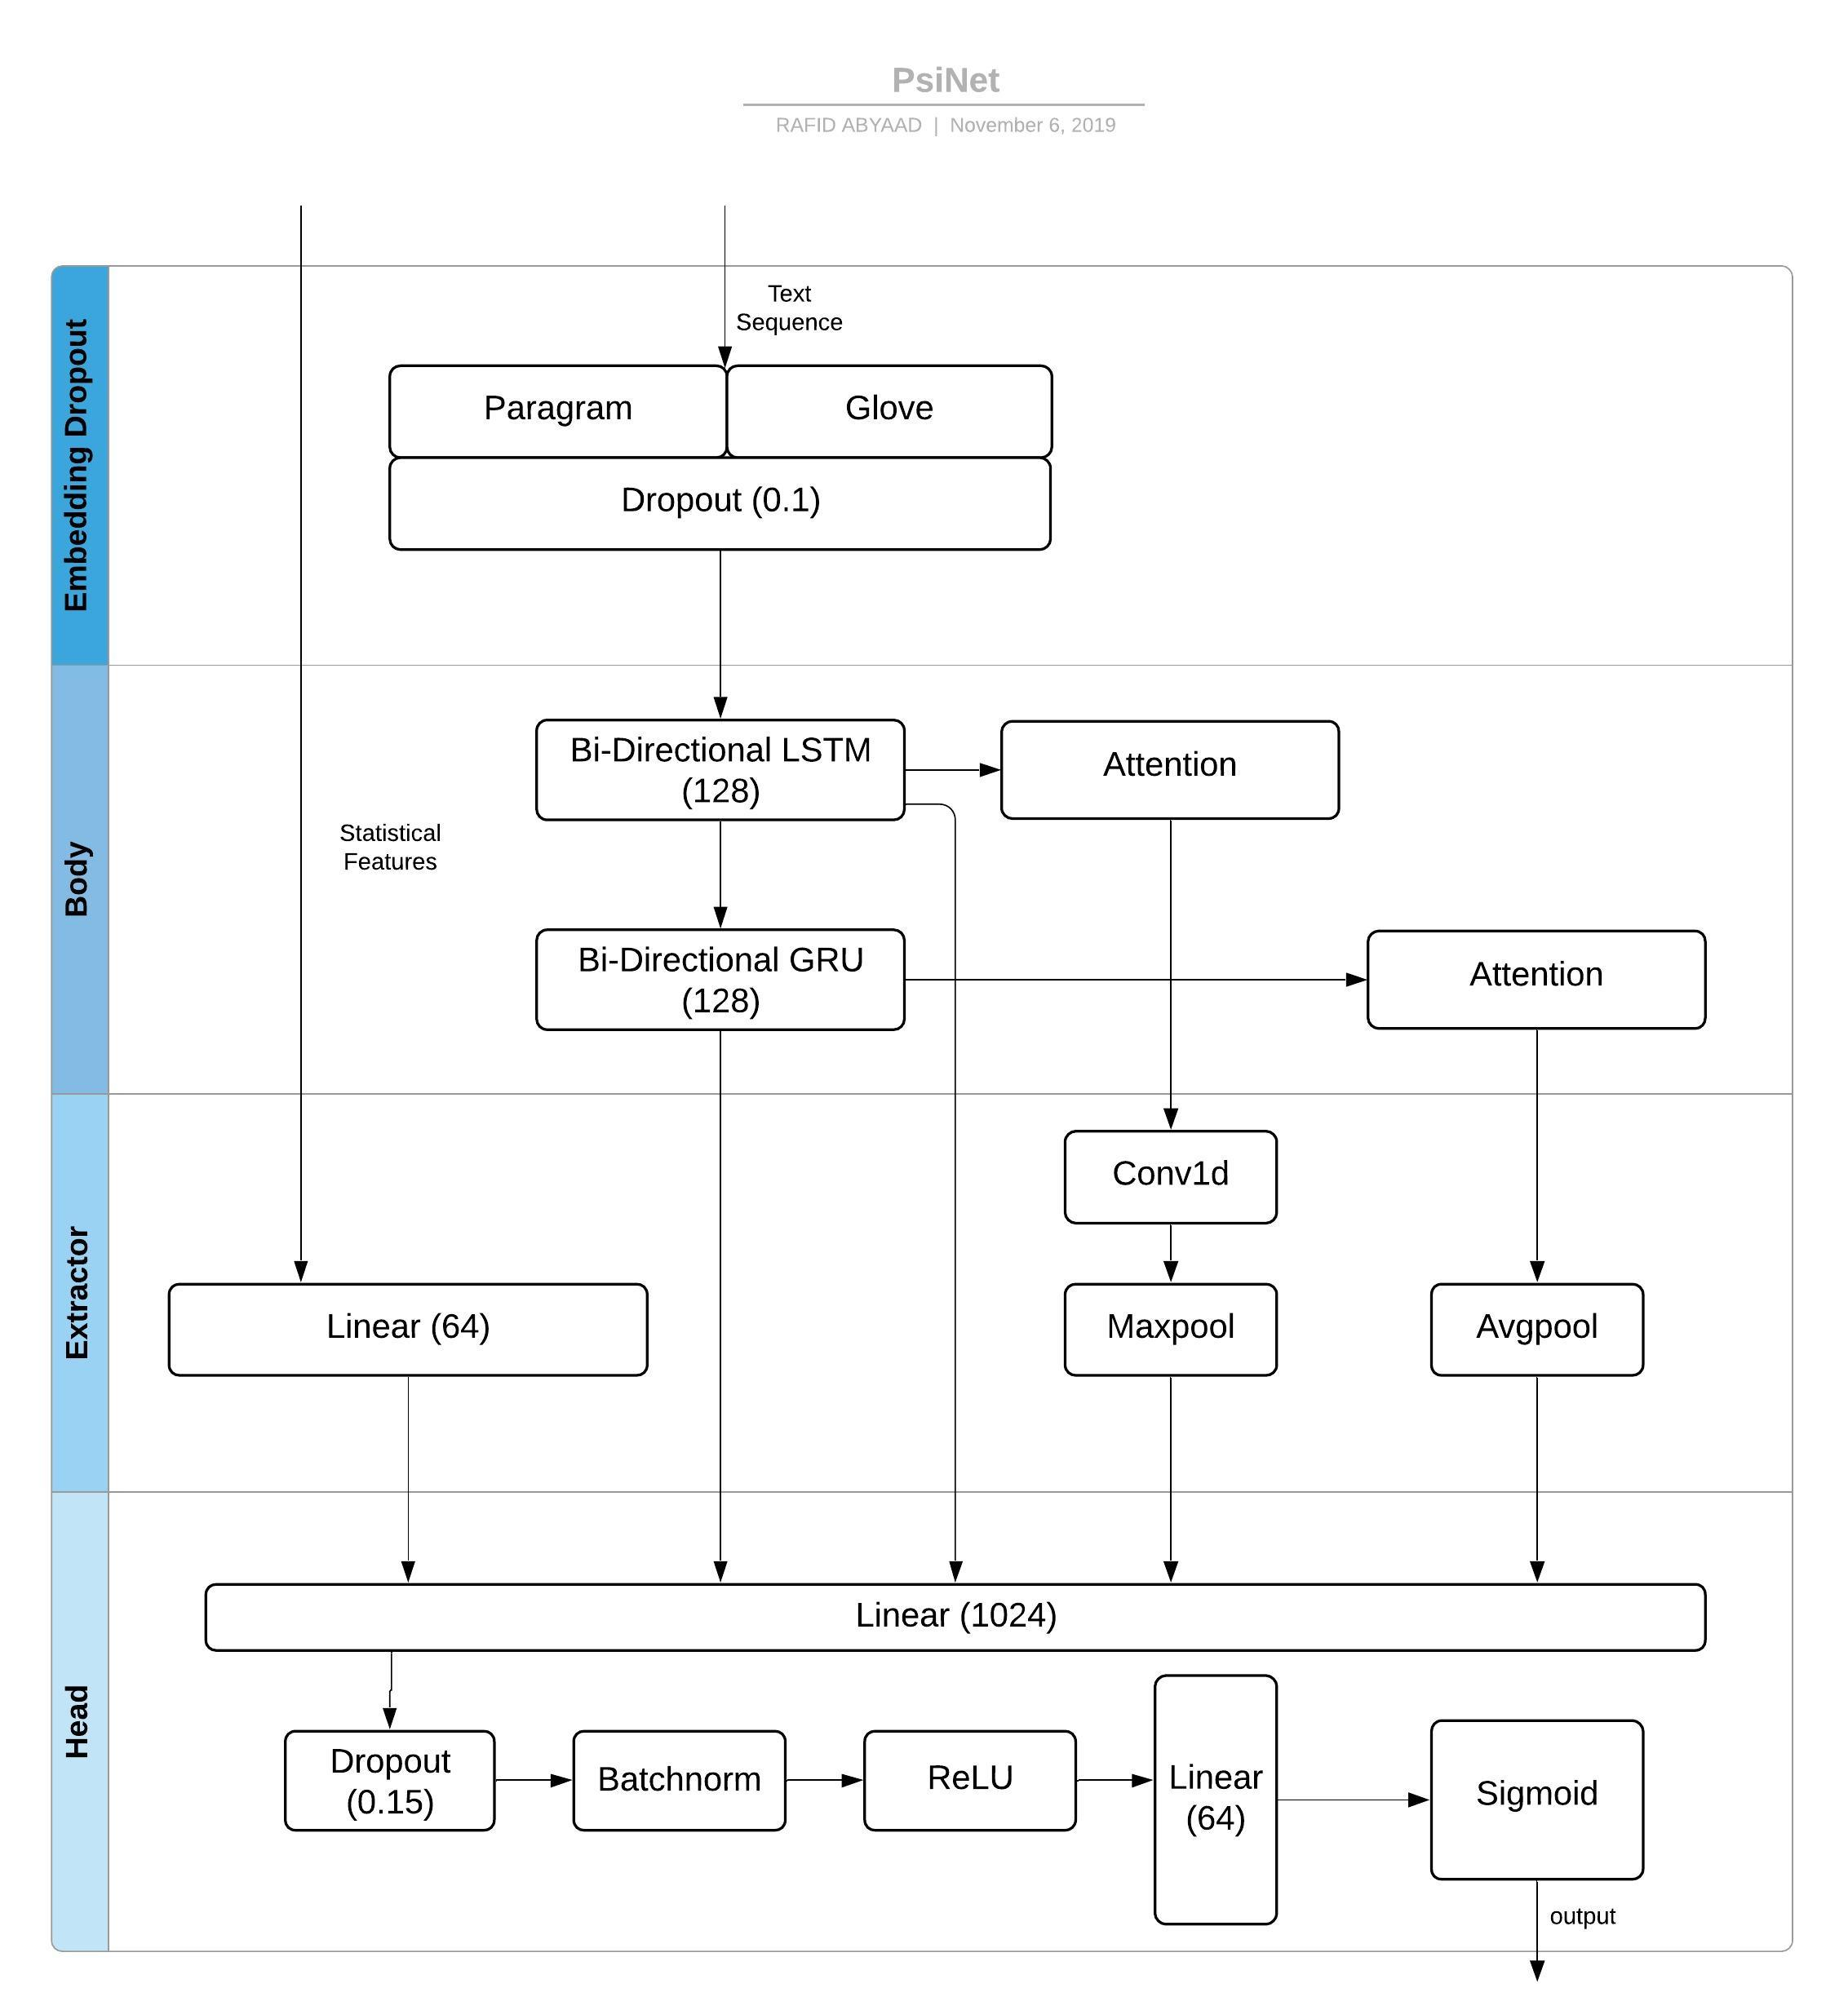

## Imports

In [ ]:
import random
import copy
import time
import pandas as pd
import numpy as np
import gc
import re
import torch
from torchtext import data
from tqdm import tqdm
from tqdm import tqdm_notebook, tnrange

tqdm.pandas(desc='Progress')

import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import f1_score
import torchtext
import os

from multiprocessing import  Pool
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import StratifiedKFold
from torch.optim.optimizer import Optimizer

from functools import partial
import numpy as np

## Basic Parameters

In [ ]:
embed_size = 300 # Word vector dimension number
max_features = 120000 # Number of unique tokens to use
maxlen = 80 # maximum sequence length for LSTM/GRU
batch_size = 512
n_epochs = 5
n_splits = 5 # K-Folds

debug = 0
# debug = 0 runs full model on GPU, debug = 1 runs a part of it on CPU. Because Weekly GPU quota.

num_embeddings = 2 # number of embedding files used

Some submissions use seeding methods for derterministic results, essentially treating them as hyperparameters, which is a bad practise. 

As Psi quoted :
> Seeing people setting the seed as a hyperparameter is weird.

I decided not to use any seeds based on his recommendation.

## Text Preprocessing and Loading
First, I needed to learn pre-processing for using word embeddings. Dieters [kernel](https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings) was a godsend for me.

I also borrowed some helper functions from this [kernel](https://www.kaggle.com/theoviel/improve-your-score-with-some-text-preprocessing).

### Punctuation and Misspelled Word Dictionary

In [ ]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]


In [ ]:
mispell_dict = {"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"}

In [ ]:
first_word_mispell_dict = {
                'whta': 'what', 'howdo': 'how do', 'Whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 
                'howmany': 'how many', 'whydo': 'why do', 'doi': 'do i', 'howdoes': 'how does', "whst": 'what', 
                'shoupd': 'should', 'whats': 'what is', "im": "i am", "whatis": "what is", "iam": "i am", "wat": "what",
                "wht": "what","whts": "what is", "whtwh": "what", "whtat": "what", "whtlat": "what", "dueto to": "due to",
                "dose": "does", "wha": "what", 'hw': "how", "its": "it is", "whay": "what", "ho": "how", "whart": "what", 
                "woe": "wow", "wt": "what", "ive": "i have","wha": "what", "wich": "which", "whic": "which", "whys": "why", 
                "doe": "does", "wjy": "why", "wgat": "what", "hiw": "how","howto": "how to", "lets": "let us", "haw": "how", 
                "witch": "which", "wy": "why", "girlfriend": "girl friend", "hows": "how is","whyis": "why is", "whois": "who is",
                "dont": "do not", "hat": "what", "whos": "who is", "whydoes": "why does", "whic": "which","hy": "why", "w? hy": "why",
                "ehat": "what", "whate": "what", "whai": "what", "whichis": "which is", "whi": "which", "isit": "is it","ca": "can", 
                "wwhat": "what", "wil": "will", "wath": "what", "plz": "please", "ww": "how", "hou": "how", "whch": "which",
                "ihave": "i have", "cn": "can", "doesnt": "does not", "shoul": "should", "whatdo": "what do", "isnt": "is not", 
                "whare": "what are","whick": "which", "whatdoes": "what does", "hwo": "how", "howdid": "how did", "why dose": "why does"
}

### Helper Functions

#### Cleaning Text and Numbers

In [ ]:
def clean_text(x):
    x = str(x)
    for punct in puncts:
        if punct in x:
            x = x.replace(punct, f' {punct} ')
    return x


def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x


#### Fixing misspellings

In [ ]:
def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re

mispellings, mispellings_re = _get_mispell(mispell_dict)
def replace_typical_misspell(text):
    def replace(match):
        return mispellings[match.group(0)]
    return mispellings_re.sub(replace, text)

def correct_first_word(x):
    for key in first_word_mispell_dict.keys():
        if x.startswith(key + " "):
            x = x.replace(key + " ", first_word_mispell_dict[key] + " ")
            break
    return x

#### Engineering Statistical features
I have extracted these statistical features from the train data.
1. Total length 
2. Capitals
3. Ratio of capitals and length	
4. Number of words	
5. Number of unique words	
6. Ratio of unique words and total words

In [ ]:
def add_features(df):
    df['question_text'] = df['question_text'].progress_apply(lambda x:str(x))
    df["lower_question_text"] = df["question_text"].apply(lambda x: x.lower())
    df['total_length'] = df['question_text'].progress_apply(len)
    df['capitals'] = df['question_text'].progress_apply(lambda comment: sum(1 for c in comment if c.isupper()))
    df['caps_vs_length'] = df.progress_apply(lambda row: float(row['capitals'])/float(row['total_length']),
                                axis=1)
    df['num_words'] = df.question_text.str.count('\S+')
    df['num_unique_words'] = df['question_text'].progress_apply(lambda comment: len(set(w for w in comment.split())))
    df['words_vs_unique'] = df['num_unique_words'] / df['num_words'] 
    return df

#### Parallel processing code for speedup

In [ ]:
def parallelize_apply(df,func,colname,num_process,newcolnames):
    pool =Pool(processes=num_process)
    arraydata = pool.map(func,tqdm(df[colname].values))
    pool.close()
    
    newdf = pd.DataFrame(arraydata,columns = newcolnames)
    df = pd.concat([df,newdf],axis=1)
    return df

def parallelize_dataframe(df, func):
    df_split = np.array_split(df, 4)
    pool = Pool(4)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

### Loading Text and Applying preprocessing

In [ ]:
if debug:
    train_df = pd.read_csv("../input/quora-insincere-questions-classification/train.csv")[:800]
    test_df = pd.read_csv("../input/quora-insincere-questions-classification/test.csv")[:200]
else:
    train_df = pd.read_csv("../input/quora-insincere-questions-classification/train.csv")
    test_df = pd.read_csv("../input/quora-insincere-questions-classification/test.csv")
print("Train shape : ",train_df.shape)
print("Test shape : ",test_df.shape)

In [ ]:
train = parallelize_dataframe(train_df, add_features)
test = parallelize_dataframe(test_df, add_features)

In [ ]:
train_df["question_text"] = train_df["question_text"].progress_apply(lambda x: x.lower())
test_df["question_text"] = test_df["question_text"].progress_apply(lambda x: x.lower())

In [ ]:
train_df["question_text"] = train_df["question_text"].progress_apply(lambda x: clean_text(x))
test_df["question_text"] = test_df["question_text"].progress_apply(lambda x: clean_text(x))

In [ ]:
train_df["question_text"] = train_df["question_text"].progress_apply(lambda x: clean_numbers(x))
test_df["question_text"] = test_df["question_text"].progress_apply(lambda x: clean_numbers(x))

In [ ]:
train_df["question_text"] = train_df["question_text"].progress_apply(lambda x: replace_typical_misspell(x))
test_df["question_text"] = test_df["question_text"].progress_apply(lambda x: replace_typical_misspell(x))

In [ ]:
train_X = train_df["question_text"].fillna("_##_").values
test_X = test_df["question_text"].fillna("_##_").values

## Tokenization

I have used keras tokenizer here. All out of vocabulary words will be replaced with special 'xxunk' token.
Tokenizer is fit on the train data and used to make sequence of texts. Then the sequences are padded so all of them have the same length. Longer sequences are truncated and shorter ones are padded.

LSTM/GRU do not like uneven sequence lengths.

In [ ]:
def tokenize_and_split(train_X,test_X):
    tokenizer = Tokenizer(num_words=max_features,oov_token = 'xxunk',filters='')
    tokenizer.fit_on_texts(list(train_X))
    train_X = tokenizer.texts_to_sequences(train_X)
    test_X = tokenizer.texts_to_sequences(test_X)

    train_X = pad_sequences(train_X, maxlen=maxlen)
    test_X = pad_sequences(test_X, maxlen=maxlen)

    train_y = train_df['target'].values
 
    trn_idx = np.random.permutation(len(train_X))

    train_X = train_X[trn_idx]
    train_y = train_y[trn_idx]
    
    features, test_features = make_stat_features()
    train_features = features[trn_idx]
    
    return train_X, test_X, train_y, train_features, test_features ,tokenizer.word_index

### Scaling Statistical Features

Calculate Statistical Features will have to be scaled before putting through a neuralnet.

As because these features have different ranges for values, some features may produce vanishing gradients. For example number of words will be, on average, a way larger value than number of unique words. So, these feaures are scaled using a standard scaler.

In [ ]:
def make_stat_features():
    
    train_features = train[['num_unique_words','words_vs_unique','total_length','capitals',
                      'caps_vs_length','num_words']].fillna(0)
    test_features = test[['num_unique_words','words_vs_unique','total_length','capitals',
                      'caps_vs_length','num_words']].fillna(0)
    
    ss = StandardScaler()
    ss.fit(np.vstack((train_features, test_features)))
    train_features = ss.transform(train_features)
    test_features = ss.transform(test_features)
    
    return train_features, test_features

In [ ]:
x_train, x_test, y_train, train_features, test_features , word_index = tokenize_and_split(train_X,test_X) 

## Loading Embeddings

1st place solution uses **0.7 \* glove + 0.3 \* paragram** matrix for its embedding layer.

In my reasoning, as these word embeddings were not trained in exactly the same system, some useful information may be lost if a weighted average is used. That is why, I have concatenated them into a **num_words \* (embedding_dim \* num_embedding)** matrix.

In [ ]:
def load_embedding(path, word_index,emb_mean, emb_std):
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(path, encoding="utf8", errors='ignore') if len(o)>100)

    all_embs = np.stack(embeddings_index.values())
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

In [ ]:
if debug:
    paragram_embeddings = np.random.randn(120000,300)
    glove_embeddings = np.random.randn(120000,300)
else:
    glove_embeddings = load_embedding('../input/quora-insincere-questions-classification/embeddings/glove.840B.300d/glove.840B.300d.txt',word_index,-0.005838499,0.48782197)    
    paragram_embeddings = load_embedding('../input/quora-insincere-questions-classification/embeddings/paragram_300_sl999/paragram_300_sl999.txt',word_index,-0.0053247833,0.49346462)

embedding_matrix = np.concatenate((glove_embeddings, paragram_embeddings), axis=1)          

## Model Definition

### Attention Module

Applying attention on LSTM and GRU outputs should boost model performance.

In [ ]:
class AttentionBlock(nn.Module):
    def __init__(self, feature_dim, step_dim, bias=True, **kwargs):
        super(AttentionBlock, self).__init__(**kwargs)
        self.supports_masking = True

        self.bias = bias
        self.feature_dim = feature_dim
        self.step_dim = step_dim
        self.features_dim = 0
        
        weight = torch.zeros(feature_dim, 1)
        nn.init.xavier_uniform_(weight)
        self.weight = nn.Parameter(weight)
        
        if bias:
            self.b = nn.Parameter(torch.zeros(step_dim))
        
    def forward(self, x, mask=None):
        feature_dim = self.feature_dim
        step_dim = self.step_dim

        eij = torch.mm(
            x.contiguous().view(-1, feature_dim), 
            self.weight
        ).view(-1, step_dim)
        
        if self.bias:
            eij = eij + self.b
            
        eij = torch.tanh(eij)
        a = torch.exp(eij)
        
        if mask is not None:
            a = a * mask

        a = a / torch.sum(a, 1, keepdim=True) + 1e-10

        weighted_input = x * torch.unsqueeze(a, -1)
        return torch.sum(weighted_input, 1)

### Embedding and Dropout Layer

Many public kernels have wrongly applied spatial droput on the batch dimension as discussed [here](https://www.kaggle.com/c/quora-insincere-questions-classification/discussion/79911).

Some reshaping was done in order to apply correct dropout on the correct dimension, i.e. feature.

In [ ]:
class EmbeddingDropout(nn.Module):
    def __init__(self, embedding_matrix, max_features = 120000, embedding_size = 300):
        super(EmbeddingDropout,self).__init__()
        self.embedding = nn.Embedding(max_features, embedding_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        
        self.embedding_drop = nn.Dropout2d(0.1)
    
    def forward(self,x):
        h_embeddings = self.embedding(x)
        h_embeddings = h_embeddings.unsqueeze(0)
        h_embeddings = h_embeddings.permute(1,3,0,2)
        h_embeddings = self.embedding_drop(h_embeddings) 
        h_embeddings = h_embeddings.permute(2,0,3,1)
        h_embeddings = h_embeddings.squeeze(0)

        return h_embeddings

### Backbone of the model

The main body of the model consists of LSTM and GRU (128).

The body returns LSTM+GRU outputs and Attention infused  LSTM+GRU outputs.

In [ ]:
class Body(nn.Module):
    def __init__ (self, embedding_size= 300, hidden_size= 128):
        super(Body,self).__init__()
        self.lstm = nn.LSTM(embedding_size*num_embeddings, hidden_size, bidirectional=True, batch_first=True)
        self.gru = nn.GRU(hidden_size*2, hidden_size, bidirectional=True, batch_first=True)
        self.hidden= hidden_size
        
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
        
        for name, param in self.gru.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
        
        self.lstm_attention = AttentionBlock(hidden_size*2, maxlen)
        self.gru_attention = AttentionBlock(hidden_size*2, maxlen)
   
    def forward(self,x):
        h_lstm, _ = self.lstm(x)
        h_gru, _ = self.gru(h_lstm)
        
        h_lstm_att = self.lstm_attention(h_lstm)
        h_gru_att = self.gru_attention(h_gru)

        return h_lstm_att, h_gru_att, h_lstm, h_gru

### Extractor Layer
This layer serves as the feature extractor for lstm, gru outputs and statistical features.

Conv1d is applied on lstm output, which goes into a maxpool.
GRU output is sent through avgpool.
Statistical Features are put through a Linear layer

In [ ]:
class Extractor(nn.Module):
    def __init__(self,maxlen= 70,hidden_size= 128,out= 64,len_feats= 6):
        super(Extractor,self).__init__()
        self.conv = nn.Conv1d(maxlen,out,kernel_size= 1,stride= 2)
        self.stat = nn.Linear(len_feats,hidden_size)
        
    def forward(self,h_lstm,h_gru,stat_features):
        conv_out = self.conv(h_lstm)
        l_maxpool, _ = torch.max(conv_out,1)
        g_avgpool = torch.mean(h_gru,1)
        statistical_features = self.stat(stat_features)
        
        return l_maxpool, g_avgpool, statistical_features   

### Output Layer

This layer consists of a dropout, a relu and a batchnorm layer, sandwiched between two linear layers.

In [ ]:
class Head(nn.Module):
    def __init__(self,embedding_size= 300,intermediate_layer=64,maxlen=70,hidden_size=128):
        super(Head,self).__init__()
        self.linear = nn.Linear(hidden_size*8,intermediate_layer)
        self.dropout = nn.Dropout(0.15)
        self.bn = nn.BatchNorm1d(intermediate_layer)
        self.output = nn.Linear(intermediate_layer, 1)
        
    def forward(self,x):
        return self.output(self.bn(self.dropout(self.linear(x))))

### Complete Model

1. First input is sent through embedding layer, returning feature vectors.
2. Embedding output is then passed to the Body of the model.
3. Extractor layer is used to find features from the sequential output of the model backbone.
4. Attention infused lstm+gru outputs and extracted features are concatenated.
5. Concatenated features are sent to the output layer.

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self, embedding_matrix,max_features=120000,embedding_size=300,
                 maxlen=70, hidden_size=128, len_feats = 6):
        super(NeuralNet,self).__init__()
        self.embedding = EmbeddingDropout(embedding_matrix,max_features= max_features,embedding_size= embedding_size)
        self.stem = Body(embedding_size,hidden_size)
        self.extractor = Extractor(maxlen= maxlen,hidden_size= hidden_size, out= 64, len_feats= len_feats)
        self.head = Head(embedding_size= embedding_size,maxlen= maxlen,hidden_size = hidden_size)
    
    def forward(self,x,stat_features):
        embedding_output = self.embedding(x)
        h_lstm_att, h_gru_att, h_lstm, h_gru = self.stem(embedding_output)
        l_maxpool, g_avgpool, extracted_feats = self.extractor(h_lstm, h_gru, stat_features)
        features = torch.cat((h_lstm_att, h_gru_att, l_maxpool, g_avgpool, extracted_feats),1)
        out = self.head(features)
        
        return out

In [ ]:
loss_fn = torch.nn.BCEWithLogitsLoss(reduction='sum')
step_size = 300

## Training

### Custom dataset

A custom dataset had to be used to keep track of the indices.

In [ ]:
class MyDataset(Dataset):
    def __init__(self,dataset):
        self.dataset = dataset
    def __getitem__(self,index):
        data,target = self.dataset[index]
        return data,target,index
    def __len__(self):
        return len(self.dataset)

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
if debug :
    x_test_cuda = torch.tensor(x_test, dtype=torch.long)
else :
    x_test_cuda = torch.tensor(x_test, dtype=torch.long).cuda()

test = torch.utils.data.TensorDataset(x_test_cuda)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

### Training Loop

Using Stratified K fold Cross Validation. Works as an ensemble.

#### GPU Loop

In [ ]:
def kfold_train(x_train,y_train,x_test, model_obj, train_features, test_features,clip = True):
    avg_losses_f = []
    avg_val_losses_f = []
    train_preds = np.zeros((len(x_train)))
    test_preds = np.zeros((len(x_test)))

    splits = list(StratifiedKFold(n_splits=n_splits, shuffle=True).split(x_train, y_train))

    for i, (train_idx, valid_idx) in tqdm(enumerate(splits)):
        x_train = np.array(x_train)
        y_train = np.array(y_train)

        x_train_fold = torch.tensor(x_train[train_idx.astype(int)], dtype=torch.long).cuda()
        y_train_fold = torch.tensor(y_train[train_idx.astype(int), np.newaxis], dtype=torch.float32).cuda()
        x_val_fold = torch.tensor(x_train[valid_idx.astype(int)], dtype=torch.long).cuda()
        y_val_fold = torch.tensor(y_train[valid_idx.astype(int), np.newaxis], dtype=torch.float32).cuda()
        
        feature_train_fold = train_features[train_idx.astype(int)]
        feature_valid_fold = train_features[valid_idx.astype(int)]
        
        model = copy.deepcopy(model_obj)
        model.cuda()

        train_ds = MyDataset(torch.utils.data.TensorDataset(x_train_fold, y_train_fold))
        valid_ds = MyDataset(torch.utils.data.TensorDataset(x_val_fold, y_val_fold))
        
        train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

        optimizer = torch.optim.Adam(model.parameters())
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer,0.01)

        print('Fold %d'%i)
        for epoch in tqdm(range(n_epochs)):
            start_time = time.time()
            avg_loss = 0.
            model.train()

            for i, (x_batch, y_batch, index) in enumerate(train_dl):
                y_pred = model(x_batch,torch.FloatTensor(feature_train_fold[index]).cuda())

                loss = loss_fn(y_pred, y_batch)
                optimizer.zero_grad()
                loss.backward()

                if clip:
                    nn.utils.clip_grad_norm_(model.parameters(),1)
                optimizer.step()
                avg_loss += loss.item() / len(train_dl)
                
            model.eval()
            
            valid_preds_fold = np.zeros((x_val_fold.size(0)))
            test_preds_fold = np.zeros((len(x_test)))
            
            avg_val_loss = 0.
            for i, (x_batch, y_batch,index) in enumerate(valid_dl):

                y_pred = model(x_batch,torch.FloatTensor(feature_valid_fold[index]).cuda()).detach()
                
                avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_dl)
                valid_preds_fold[index] = sigmoid(y_pred.cpu().numpy())[:, 0]
            
            elapsed_time = time.time() - start_time 

            print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f} \t time={:.2f}s'
                  .format(epoch + 1, n_epochs, avg_loss, avg_val_loss, elapsed_time))
        
        avg_losses_f.append(avg_loss)
        avg_val_losses_f.append(avg_val_loss) 

        for i, (x_batch,) in enumerate(test_loader):
            y_pred = model(x_batch,torch.FloatTensor(test_features[i * batch_size:(i+1) * batch_size]).cuda())
            test_preds_fold[i * batch_size:(i+1) * batch_size] = sigmoid(y_pred.detach().cpu().numpy())[:, 0] 
        
        train_preds[valid_idx] = valid_preds_fold
        test_preds += test_preds_fold / len(splits)

    print('All \t loss={:.4f} \t val_loss={:.4f} \t '.format(np.average(avg_losses_f),np.average(avg_val_losses_f)))
    return train_preds, test_preds

#### CPU Loop

For debugging without GPU

In [ ]:
def cpu_kfold_train(x_train,y_train,x_test, model_obj, train_features, test_features,clip = True):
    avg_losses_f = []
    avg_val_losses_f = []

    train_preds = np.zeros((len(x_train)))
    test_preds = np.zeros((len(x_test)))

    splits = list(StratifiedKFold(n_splits=n_splits, shuffle=True).split(x_train, y_train))

    for i, (train_idx, valid_idx) in tqdm(enumerate(splits)):
        x_train = np.array(x_train)
        y_train = np.array(y_train)

        x_train_fold = torch.tensor(x_train[train_idx.astype(int)], dtype=torch.long)
        y_train_fold = torch.tensor(y_train[train_idx.astype(int), np.newaxis], dtype=torch.float32)
        x_val_fold = torch.tensor(x_train[valid_idx.astype(int)], dtype=torch.long)
        y_val_fold = torch.tensor(y_train[valid_idx.astype(int), np.newaxis], dtype=torch.float32)
        
        feature_train_fold = train_features[train_idx.astype(int)]
        feature_valid_fold = train_features[valid_idx.astype(int)]
        
        model = copy.deepcopy(model_obj)

        train_ds = MyDataset(torch.utils.data.TensorDataset(x_train_fold, y_train_fold))
        valid_ds = MyDataset(torch.utils.data.TensorDataset(x_val_fold, y_val_fold))
        
        train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

        optimizer = torch.optim.Adam(model.parameters())
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer,0.01)

        print(f'Fold {i + 1}')
        for epoch in tqdm(range(n_epochs)):
            start_time = time.time()
            avg_loss = 0.
            model.train()

            for i, (x_batch, y_batch, index) in tqdm(enumerate(train_dl)):
                y_pred = model(x_batch,torch.FloatTensor(feature_train_fold[index]))

                loss = loss_fn(y_pred, y_batch)
                optimizer.zero_grad()
                loss.backward()

                if clip:
                    nn.utils.clip_grad_norm_(model.parameters(),1)
                optimizer.step()
                avg_loss += loss.item() / len(train_dl)
                
            model.eval()
            
            valid_preds_fold = np.zeros((x_val_fold.size(0)))
            test_preds_fold = np.zeros((len(x_test)))
            
            avg_val_loss = 0.
            for i, (x_batch, y_batch,index) in tqdm(enumerate(valid_dl)):

                y_pred = model(x_batch,torch.FloatTensor(feature_valid_fold[index])).detach()
                
                avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_dl)
                valid_preds_fold[index] = sigmoid(y_pred.detach().numpy())[:, 0]
            
            elapsed_time = time.time() - start_time 

            print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f} \t time={:.2f}s'.format(epoch + 1, n_epochs, avg_loss, avg_val_loss, elapsed_time))
        
        avg_losses_f.append(avg_loss)
        avg_val_losses_f.append(avg_val_loss) 

        for i, (x_batch,) in tqdm(enumerate(test_loader)):
            y_pred = model(x_batch,torch.FloatTensor(test_features[i * batch_size:(i+1) * batch_size]))
            test_preds_fold[i * batch_size:(i+1) * batch_size] = sigmoid(y_pred.detach().numpy())[:, 0] 
        
        train_preds[valid_idx] = valid_preds_fold
        test_preds += test_preds_fold / len(splits)

    print('All \t loss={:.4f} \t val_loss={:.4f} \t '.format(np.average(avg_losses_f),np.average(avg_val_losses_f)))
    return train_preds, test_preds

In [ ]:
model = NeuralNet(embedding_matrix,maxlen=maxlen,max_features=len(embedding_matrix))

In [ ]:
if debug:
    train_preds, test_preds = cpu_kfold_train(x_train,y_train,x_test,model,train_features,test_features)
else :
    train_preds, test_preds = kfold_train(x_train,y_train,x_test,model,train_features,test_features)

### Choosing the best threshold for classification

In [ ]:
def findthreshold (y_train, train_preds):
    best_f1= 0
    best_thresh= 0
    for thresh in tqdm(np.arange(0.1,0.501,0.01)):
        f1 = f1_score(y_train,(train_preds>thresh))
        if f1 > best_f1:
            best_thresh = thresh
            best_f1 = f1
    print('best threshold is {:.4f} with F1 score: {:.4f}'.format(best_thresh, best_f1))
    return best_thresh, best_f1

threshold, score = findthreshold(y_train,train_preds)

## Submit

In [ ]:
if debug:
    df_test = pd.read_csv("../input/quora-insincere-questions-classification/test.csv")[:200]
else:
    df_test = pd.read_csv("../input/quora-insincere-questions-classification/test.csv")
submission = df_test[['qid']].copy()
submission['prediction'] = (test_preds > threshold).astype(int)
submission.to_csv('submission.csv', index=False)